### 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

In [234]:
# Setup imports
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf

from tensorflow.keras import layers, Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

%reload_ext tensorboard

In [2]:
# Setup constants
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
INITIAL_EPOCHS = 10

In [3]:
# Create training and test dirs
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [4]:
# Setup data loaders
train_data_10_percent = image_dataset_from_directory(directory=train_dir_10_percent,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(directory=test_dir,
                                         image_size=IMG_SIZE,
                                         label_mode="categorical",
                                         batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights_exercise/checkpoint.ckpt"

# Create a ModelCheckpont callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",   # save every epoch
                                                         verbose=1)

In [6]:
# Setup input shape and base model, freezing the base model layers
input_shape = IMG_SHAPE
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = Model(inputs, outputs)

# Compile the model
model_1.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_model_1 = model_1.fit(train_data_10_percent,
                              epochs=INITIAL_EPOCHS,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              # Track model training logs
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning_exercise",
                                                                     experiment_name="10_percent_data_base"),
                                         checkpoint_callback])

Saving TensorBoard log files to: transfer_learning_exercise/10_percent_data_base/20221013-170909
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8495 - accuracy: 0.4120
Epoch 1: saving model to 10_percent_model_checkpoints_weights_exercise\checkpoint.ckpt
24/24 [==============================] - 19s 718ms/step - loss: 1.8495 - accuracy: 0.4120 - val_loss: 1.2986 - val_accuracy: 0.7220
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.7733
Epoch 2: saving model to 10_percent_model_checkpoints_weights_exercise\checkpoint.ckpt
24/24 [==============================] - 16s 694ms/step - loss: 1.0411 - accuracy: 0.7733 - val_loss: 0.8898 - val_accuracy: 0.7911
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.8453
Epoch 3: saving model to 10_percent_model_checkpoints_weights_exercise\checkpoint.ckpt
24/24 [==============================] - 16s 689ms/step - loss: 0.7402 - accuracy: 0.8453 - val_

In [7]:
# Evaluate on the full test data
model_1_results = model_1.evaluate(test_data)

79/79 [==============================] - 29s 369ms/step - loss: 0.4416 - accuracy: 0.8740


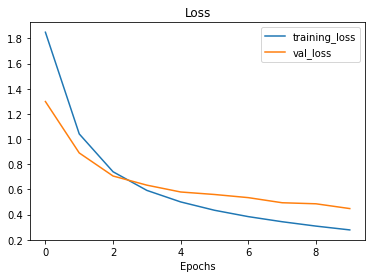

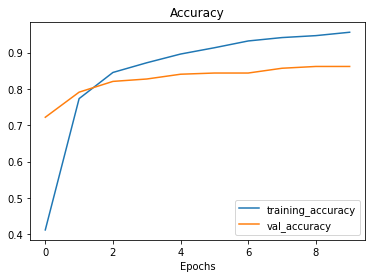

In [8]:
# Plot loss and accuracy curves
plot_loss_curves(history_model_1)

### 2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?

In [9]:
# Load in saved model weights
model_1.load_weights(checkpoint_path)

In [10]:
# To begin fine-tuning, let's start by setting the last 20 layers of our base_model to trainable = True
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile (we have to recompile our models every time we make a change)
model_1.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(learning_rate=0.0001),  # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

In [43]:
# Check our base_model (EfficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_1.layers[1].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [11]:
# Fine tune for another 10 epochs
fine_tune_epochs = INITIAL_EPOCHS + 10

# Refit the model (same as model_1 except with more trainable layers)
history_model_2 = model_1.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_model_1.epoch[-1],  # start training from previous last epoch
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning_exercise",
                                                                     experiment_name="10_percent_data_fine_tune_20")])

Saving TensorBoard log files to: transfer_learning_exercise/10_percent_data_fine_tune_20/20221013-171224
Epoch 10/20
24/24 [==============================] - 19s 724ms/step - loss: 0.2571 - accuracy: 0.9653 - val_loss: 0.4697 - val_accuracy: 0.8553
Epoch 11/20
24/24 [==============================] - 16s 684ms/step - loss: 0.2512 - accuracy: 0.9653 - val_loss: 0.4533 - val_accuracy: 0.8635
Epoch 12/20
24/24 [==============================] - 16s 676ms/step - loss: 0.2469 - accuracy: 0.9667 - val_loss: 0.4752 - val_accuracy: 0.8520
Epoch 13/20
24/24 [==============================] - 16s 683ms/step - loss: 0.2428 - accuracy: 0.9680 - val_loss: 0.4540 - val_accuracy: 0.8668
Epoch 14/20
24/24 [==============================] - 16s 674ms/step - loss: 0.2391 - accuracy: 0.9680 - val_loss: 0.4646 - val_accuracy: 0.8470
Epoch 15/20
24/24 [==============================] - 16s 674ms/step - loss: 0.2351 - accuracy: 0.9680 - val_loss: 0.4540 - val_accuracy: 0.8602
Epoch 16/20
24/24 [============

In [12]:
# Evaluate on the full test data
model_2_results = model_1.evaluate(test_data)

79/79 [==============================] - 29s 371ms/step - loss: 0.4195 - accuracy: 0.8776


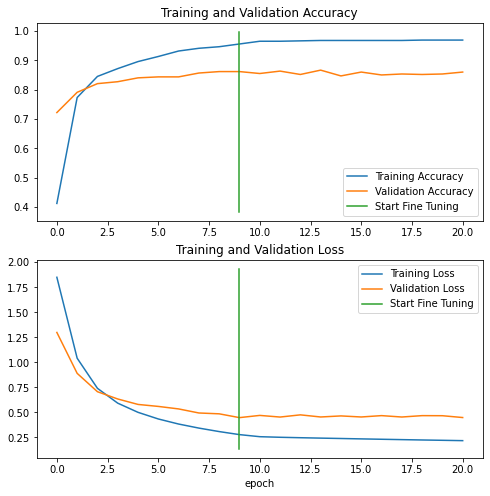

In [13]:
# Plot loss and accuracy curves
compare_historys(original_history=history_model_1,
                 new_history=history_model_2,
                 initial_epochs=INITIAL_EPOCHS)

### 3. Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?

In [14]:
# Load in saved model weights
model_1.load_weights(checkpoint_path)

In [15]:
# Setting the last 30 layers of our base_model to trainable = True
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile (we have to recompile our models every time we make a change)
model_1.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(learning_rate=0.0001),  # when fine-tuning you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

In [44]:
# Check our base_model (EfficientNetB0) and see what layers are trainable
for layer_number, layer in enumerate(model_1.layers[1].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [16]:
# Fine tune for another 10 epochs
fine_tune_epochs = INITIAL_EPOCHS + 10

# Refit the model
history_model_3 = model_1.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_model_1.epoch[-1],  # start training from previous last epoch
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning_exercise",
                                                                     experiment_name="10_percent_data_fine_tune_30")])

Saving TensorBoard log files to: transfer_learning_exercise/10_percent_data_fine_tune_30/20221013-171553
Epoch 10/20
24/24 [==============================] - 19s 705ms/step - loss: 0.2575 - accuracy: 0.9640 - val_loss: 0.4980 - val_accuracy: 0.8520
Epoch 11/20
24/24 [==============================] - 16s 669ms/step - loss: 0.2510 - accuracy: 0.9667 - val_loss: 0.4776 - val_accuracy: 0.8569
Epoch 12/20
24/24 [==============================] - 16s 679ms/step - loss: 0.2468 - accuracy: 0.9680 - val_loss: 0.4587 - val_accuracy: 0.8602
Epoch 13/20
24/24 [==============================] - 16s 693ms/step - loss: 0.2429 - accuracy: 0.9680 - val_loss: 0.4571 - val_accuracy: 0.8602
Epoch 14/20
24/24 [==============================] - 16s 676ms/step - loss: 0.2387 - accuracy: 0.9680 - val_loss: 0.4716 - val_accuracy: 0.8487
Epoch 15/20
24/24 [==============================] - 16s 672ms/step - loss: 0.2350 - accuracy: 0.9680 - val_loss: 0.4642 - val_accuracy: 0.8618
Epoch 16/20
24/24 [============

In [17]:
# Evaluate on the full test data
model_3_results = model_1.evaluate(test_data)

79/79 [==============================] - 30s 374ms/step - loss: 0.4198 - accuracy: 0.8776


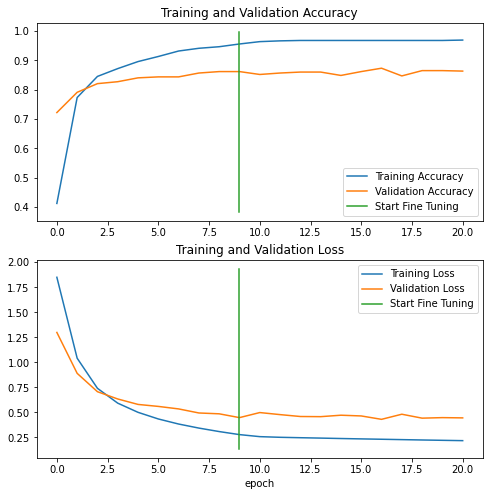

In [18]:
# Plot loss and accuracy curves
compare_historys(original_history=history_model_1,
                 new_history=history_model_3,
                 initial_epochs=INITIAL_EPOCHS)

In [45]:
# Compare results
model_1_results, model_2_results, model_3_results

([0.4415774941444397, 0.8740000128746033],
 [0.41945868730545044, 0.8776000142097473],
 [0.4197666049003601, 0.8776000142097473])

In [48]:
# Compare models in TensorBoard
# %reload_ext tensorboard
%tensorboard --logdir="transfer_learning_exercise"

### 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [339]:
def pred_and_plot(model, dataset):
    class_names = dataset.class_names
    sample_index = random.randint(0, 31)

    sample = dataset.take(1).unbatch()
    sample = list(sample.as_numpy_iterator())[sample_index]
    sample_image = sample[0]
    sample_class = class_names[tf.math.argmax(sample[1])]

    pred = model.predict(tf.expand_dims(sample_image, axis=0), verbose=0)
    pred_class = class_names[tf.math.argmax(pred[0])]
    plt.imshow(sample_image.astype('uint8'))
    plt.title(f"Pred: {pred_class}, Actual: {sample_class}, Prob: {pred.max():.2f}")
    plt.axis("off")

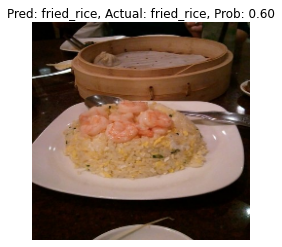

In [364]:
pred_and_plot(model_1, test_data)